# Problem Set 4

## Problem 1: Galaxy Photometric Redshifts (6 points)

Let us return to an example from cosmology. Many of the galaxies we observe with telescopes are millions of light years away. Because the Universe has expanded since the light of a galaxy was emitted, its light is shifted towards longer wavelengths, i.e., redder parts of the electromagnetic spectrum. This effect, which is called redshift, can be measured precisely with spectroscopy. However, spectroscopy is time-consuming and challenging for a large number of galaxies. Thus, a common problem in astronomy is trying to estimate the redshift of a galaxy by looking only at its flux or intensity in different parts, so-called bands, of the electromagnetic spectrum. Redshifts estimated this way are called photometric redshifts.

The file `Problem_Set_4_Redshifts.csv` contains the following data.
* `<BAND>_FLUX`: Fluxes in different bands. This is what will be used for training. Note that the data has been cleaned, and galaxies with missing fluxes have been removed.
* `Z_PHOT`: This is the redshift estimated from a state-of-the-art photometric redshift code, [LePHARE](https://lephare.readthedocs.io/en/latest/). You should **not** use this during training or validation. It's simply another estimate to compare against.
* `Z_SPEC`: These are spectroscopic redshifts $z_\mathrm{spec}$ measured from the Dark Energy Spectroscopic Instrument (DESI).

(For those interested, fluxes and photometric redshifts come from the [COSMOS2020 catalog](https://cosmos2020.calet.org/). The spectroscopic redshifts are available [here](https://data.desi.lbl.gov/public/papers/c3/cosmos-xmmlss/). The script `make_problem_set_4.py` "reduces" the publicly available data sets to `Problem_Set_4_Redshifts.csv`.)

(a) Make a histogram of the spectroscopic redshifts, $z_\mathrm{spec}$. Additionally, compute the $R^2$ score of a simple linear model as a baseline to compare against.

(b) Use a random forest to predict the spectroscopic redshift from the measured fluxes. Perform a $k$-fold cross-validation with $k=10$ to optimize hyperparameters based on the $R^2$ score. Include (+/- 1 standard deviation) error bars derived from the scatter between different folds. To keep the compute time reasonable, limit the number of trees in the random forest to $30$. How does the score of the random forest compare against the linear model? I'm not grading you on having found the absolute best hyperparameters as long as the cross-validation search is reasonable, that is, testing a few values for $3$ or $4$ hyperparameters within reasonable ranges. (Tip: You probably want to use `n_jobs=-1` in `sklearn.ensemble.RandomForestRegressor` to make the random forest use as many CPU cores as possible.)

(c) Compute the cross-validated $R^2$ training curve for the best-performing hyperparameters with with the number of training samples $n$ going from $1000$ to $10000$. As for (b), please include error bars. Does this curve indicate significant overfitting? Would our random forest redshifts benefit meaningfully from more training data?

(d) In astronomy, we are often interested in the catastrophic outlier rate $\eta$ of redshifts. This rate is defined as the fraction of photometric redshifts $\hat z$ for which $|\hat z - z_\mathrm{spec}| > 0.15 (1 + z_\mathrm{spec})$. Thus, another "score" we are interested in is $1 - \eta$, the fraction of redshifts that are not catastrophic outliers. Plot the learning curve for the cross-validated $1 - \eta$ score and indicate the catastrophic outlier rate of the LePHARE photometric redshifts in the same plot. (Hint: `sklearn.model_selection` can take a custom score function via the `scoring` keyword argument. More information can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#custom-scorer-objects-from-scratch).)

(e) Visualize the feature importance in the random forest. What does this indicate about the importance of different photometric bands?

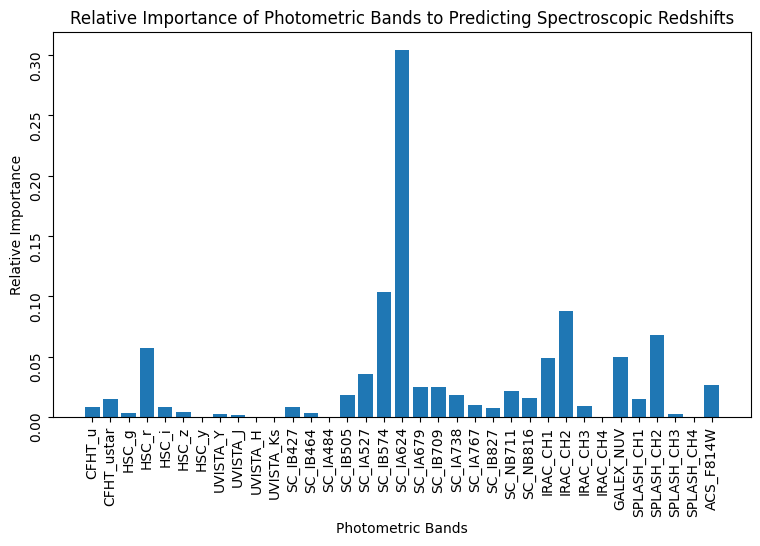

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("Problem_Set_4_Redshifts.csv")
y = df["Z_SPEC"]
X = df.iloc[:, :35] # all fluxes
y_est = df["Z_PHOT"]
flux_names = X.columns

k_num = 10
kfold = model_selection.KFold(n_splits=k_num, shuffle=True)

z_spec_cv = []

# returns 1 - n for y_pred
def score_spec_catastropic(random_forest, X, z_spec):
    length = len(z_spec)
    y_pred = random_forest.predict(X)

    num_catastropic = 0
    for i in range(length):
        if abs(y_pred[i] - z_spec.iloc[i]) > 0.15 * (1 + z_spec.iloc[i]):
            num_catastropic += 1

    percent_catastropic = num_catastropic / length
    return 1 - percent_catastropic

# return n for z_phot
def phot_catastrophic():
    length = len(y_est)
    num_catastropic = 0
    for i in range(length):
        if abs(y_est[i] - y.iloc[i]) > 0.15 * (1 + y.iloc[i]):
            num_catastropic += 1
    return num_catastropic / length

def a():
    plt.yscale("log")
    plt.hist(df["Z_SPEC"], bins = 50)
    plt.title("Spectroscopic Redshift Distribution")
    plt.xlabel("Z Spec")
    plt.ylabel("Count")
    plt.show()

    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)
    linear_r2 = metrics.r2_score(y_est, y_pred)
    print("Linear Regression R2 Score:", linear_r2)

def b():
    model = model_selection.GridSearchCV(RandomForestRegressor(), dict(n_estimators = range(30, 31), n_jobs = range(-1, 0), min_impurity_decrease = np.linspace(0.005, 0.1, 3), max_depth = range(4, 8), max_samples = range(230, 245, 5)), cv = kfold, scoring = "r2").fit(X, y)
    params = model.cv_results_["params"]
    mean_scores = model.cv_results_["mean_test_score"]
    std_scores = model.cv_results_["std_test_score"]

    param_list = []
    for permutation in params:
        # remove ending braces
        new_p = str(permutation)[1:-1]
        # remove n_estimators and n_jobs
        new_p = new_p[:-35]
        # remove quotations
        new_p = new_p.replace("'", "")
        new_p = new_p.replace("np.float64(", "")
        param_list.append(new_p)

    fig, ax = plt.subplots(figsize = (12, 8))
    ax.tick_params(rotation=90)
    ax.bar(param_list, mean_scores, yerr = std_scores)
    ax.set_ylabel("Mean R2 Test Score")
    ax.set_xlabel("Hyperparameters")
    ax.set_title("Hyperparameter R2 Scores (n_estimators = 30, n_jobs = -1)")
    plt.show()

    print(model.best_params_)

def c():
    random_forest = RandomForestRegressor(n_estimators=30, n_jobs=-1, min_impurity_decrease=0.005, max_depth=5, max_samples=235)
    n_list = range(1000, 10001, 50)
    # train scores = [n_ticks][n_cv_folds] scores on training sets
    # validation scores = [n_ticks][n_cv_folds] scores on test sets
    train_sizes, train_scores, validation_scores = model_selection.learning_curve(random_forest, X, y, train_sizes=n_list, cv=kfold, scoring='r2')
    cv_train_score_list = np.mean(train_scores, axis = 1)
    cv_std_scores = np.std(train_scores, axis = 1)

    plt.ylim(0, 0.8)
    plt.plot(n_list, cv_train_score_list)
    plt.fill_between(n_list, cv_train_score_list - cv_std_scores, cv_train_score_list + cv_std_scores, alpha=0.2)
    plt.title(f"Random Forest Regressor R2 Scores based on Number of Samples\nmax_depth = 7, max_samples = 240, min_impurity_decrease = 0.005")
    plt.xlabel("Number of Samples")
    plt.ylabel("R2 Score")
    plt.show()

def d():
    random_forest = RandomForestRegressor(n_estimators=30, n_jobs=-1, min_impurity_decrease=0.005, max_depth=5, max_samples=235)
    train_sizes, train_scores, validation_scores = model_selection.learning_curve(random_forest, X, y, cv=kfold, scoring=score_spec_catastropic)
    cv_train_score_list = np.mean(train_scores, axis = 1)

    phot_score = phot_catastrophic()
    percent_trained = train_sizes / len(y)

    plt.plot(percent_trained, cv_train_score_list, label = r"Spectroscopic CV $1 - \eta$ Scores")
    plt.hlines(phot_score, min(percent_trained), max(percent_trained), label = r"Photometric $\eta$ Rate", color = "orange")
    plt.title(r"Learning Curve of CV $1 - \eta$  Training Scores")
    plt.xlabel("Percent of Data Trained On")
    plt.ylabel("Percent of Non-Catastrophic Outliers")
    plt.legend(loc = "center right")
    plt.show()

def e():
    random_forest = RandomForestRegressor(n_estimators=30, n_jobs=-1, min_impurity_decrease=0.005, max_depth=5, max_samples=235).fit(X, y)
    fig, ax = plt.subplots(figsize = (9, 5))
    ax.tick_params(rotation=90)

    # cleaning up string names
    headers = []
    for header in X.columns:
        new_header = header.replace("_FLUX", "")
        headers.append(new_header)

    plt.bar(headers, random_forest.feature_importances_)
    plt.xlabel('Photometric Bands')
    plt.ylabel('Relative Importance')
    plt.title('Relative Importance of Photometric Bands to Predicting Spectroscopic Redshifts')
    plt.show()
a()
b()
c()
d()
e()

C) Because the curve does not increase with the number of samples, the model is probably not overfitted. Because the forest's R2 score remains mostly constant over time, the model will probably not benefit from more data.
E) The most important photometric band is SC_IA624. SC_IB574, IPAC_CH2, and HSC_r may also have some importance, but they seem to be susceptible to scatter.